## Analysis of data from both monkeys using a variaty of LFADS hyperparameters.

For these analyses, I analyzed data both from two monkeys--Rockstar, the original dataset I looked at, and Raju. Both datasets contain about 100 neurons, but with the Rockstar dataset all of the neurons are in M1, and in Raju they are about evenly split between M1 and PMd. I ran LFADS for both over a range of hyperparameters dealing with weight regularization and the weight of the objective function penalizing the inputs. I ran all of these on the original LFADS and a version I modified to find find sparse input solutions. To do this I modified the prior on the input to be a Laplace AR(1) process as opposed to a Gaussian AR(1). Below I'm plotting the performance across all of the hyperparameter sets, sorted from best performance to worst in predicting position of the target from the input in hand-centric Cartiesian coordinates. (Further below I will evaluate using other metrics). I'm using cross-validated r^2, and the error bars represent different test sets.

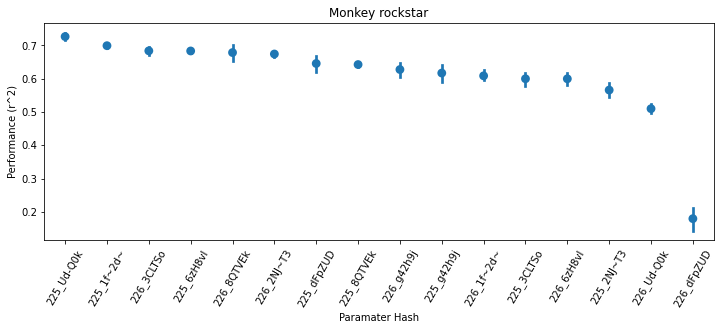

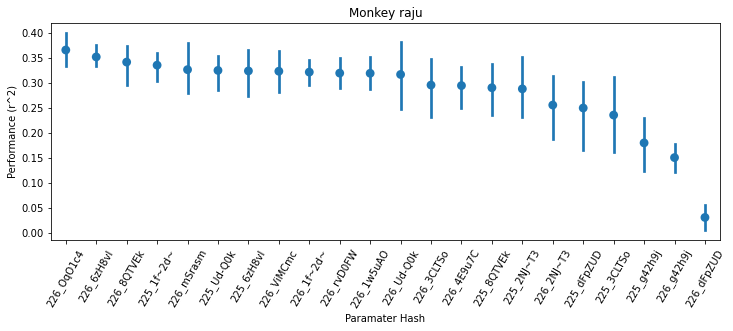

In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
from predict_targets import predict_targets
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

cfg = yaml.load(open('../config.yml'))

for dataset in ['rockstar', 'raju']:
    param_list = []
    performance = []
    k=0
    for param in cfg['datasets'][dataset]['params'].keys():
        df = pd.read_pickle('../data/processed_inputs/' + '%s_%s_all.p'%(dataset, param))
        scores = predict_targets(df, metric='cartesian')
        performance += list(scores)
        if '226' in param:
            param = 'sparse_' + param[4:]
        else:
            param = param[4:]
        param_list += [param]*len(scores)

    plot_df = pd.DataFrame(data={'Performance (r^2)':np.array(performance),
                                'Paramater Hash':np.array(param_list)})

    a=plot_df.groupby('Paramater Hash').mean().sort_values('Performance (r^2)', ascending=False)
    plt.figure(figsize=(12,4))
    g=sns.pointplot(x='Paramater Hash', y='Performance (r^2)', data=plot_df, join=False, order=a.index.values)
    g.set_xticklabels(g.get_xticklabels(), rotation=60)
    plt.title('Monkey %s'%dataset)


The sixth-best performing solution, which performs nearly as well as the top five, gives a sparse solution with mostly distcrete input pulses. The performance in predicting target position for this sparse solution is somewhat better than the best solution I had on the first pass ($r^2 \approx 0.69$ vs $r^2 \approx 0.6$. On the right are some of the inputs plotted for this solution, which uses the sparse prior. On the left is the solution using the same hyperparameters but using the Gaussian prior. The vertical black lines represent target appearances. 

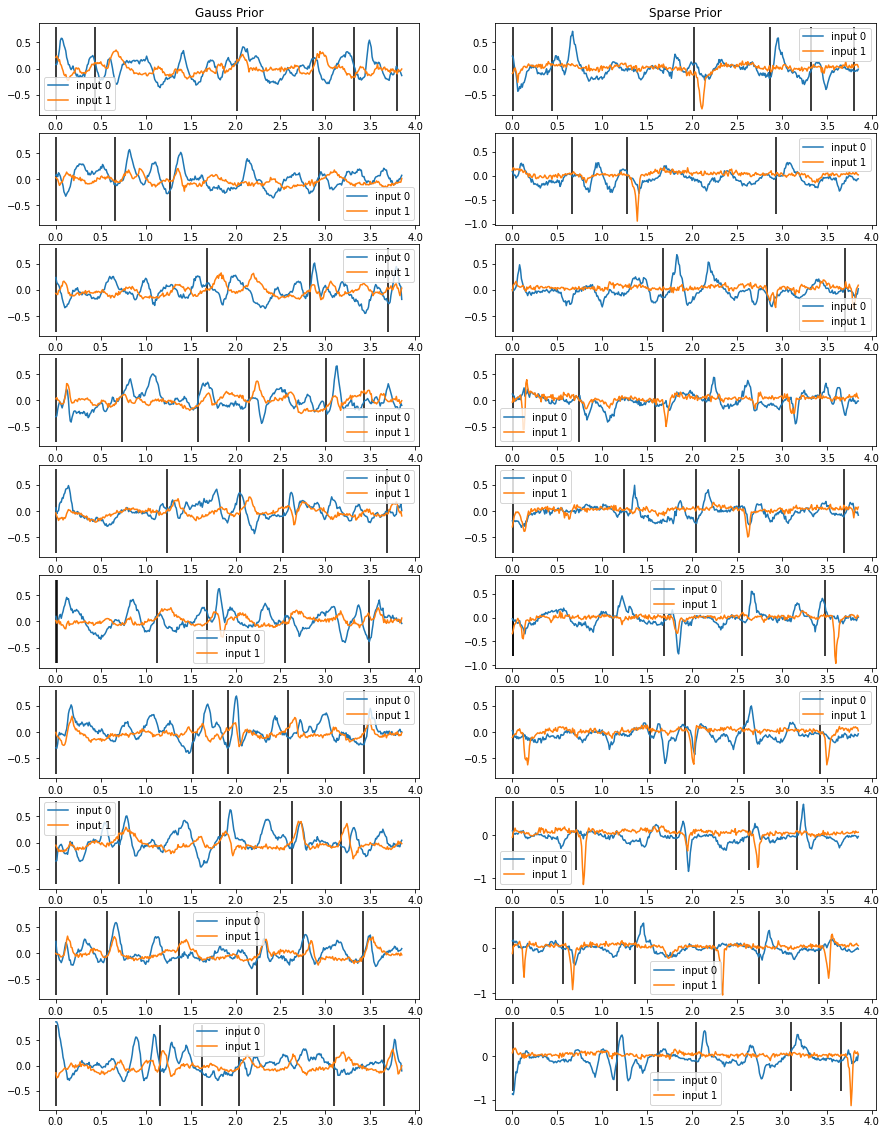

In [5]:
from scipy.io import loadmat
import sys
import h5py
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
from utils import get_indices
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

trial_type = 'all'

sparse_filename = "/home/pmalonis/226_figs/rockstar_8QTVEk_%s.h5"%trial_type
gauss_filename = "/home/pmalonis/225_figs/rockstar_8QTVEk_%s.h5"%trial_type
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/rockstar.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/rockstar_inputInfo.mat"

input_info = loadmat(inputInfo_filename)
used_inds = get_indices(input_info, trial_type)

df = pd.read_pickle(data_filename)
ntrials = 10

with h5py.File(gauss_filename) as gauss_h5:
    with h5py.File(sparse_filename) as sparse_h5:
        trial_len_ms = input_info['seq_timeVector'][-1][-1]
        dt = np.round(trial_len_ms/gauss_h5['controller_outputs'].shape[1])/1000 
        trial_len = trial_len_ms/1000
        trial_len = np.floor(trial_len/dt)*dt
        lfads_t = np.arange(0, trial_len, dt)
        plt.figure(figsize=(15,20))
        for j, (h5file,title) in enumerate(zip([gauss_h5, sparse_h5], ['Gauss Prior', 'Sparse Prior'])):
            for i, trial_idx in enumerate(used_inds[:ntrials]):
                plt.subplot(ntrials, 2, i*2 + j + 1)
                n_inputs = h5file['controller_outputs'].shape[2]
                targets = df.loc[trial_idx].kinematic.loc[:trial_len].query('hit_target').index.values
                plt.vlines(targets, -.8,.8)
                legend = []
                for input_idx in range(n_inputs):
                    plt.plot(lfads_t, h5file['controller_outputs'][i,:,input_idx])
                    legend.append('input %d'%input_idx)

                if i == 0:
                    plt.title(title)
                plt.legend(legend)

The orange input tends to appear following target appearances, and the blue input seems to be associated with corrections during reaching. To show an example of the latter, in the email I've attached a video that shows a slowed-down trial along with a scrolling plot of the input. Around 2 s into the trial, the monkey makes a series of three corrections in the course of hitting a single target. These corrections coincide with a multiphasic signal in the blue input. I'm still thinking about how best to analyze this. Below are some plots of trials from this run, where I have also plotted the angle between the hand velocity vector and vector pointing from the hand to the target.  

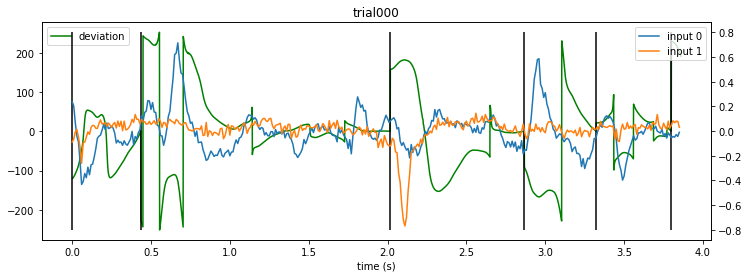

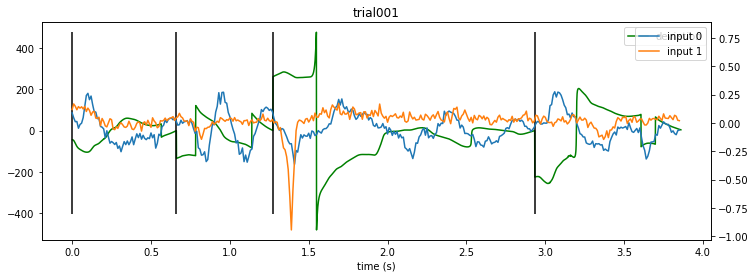

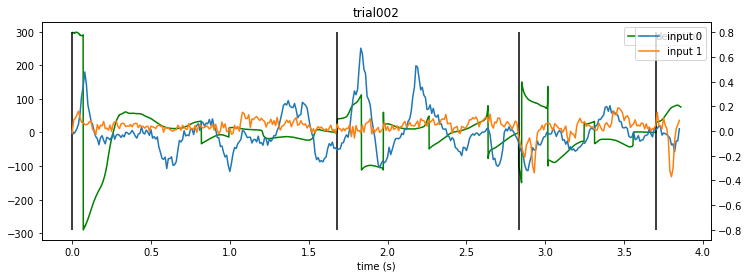

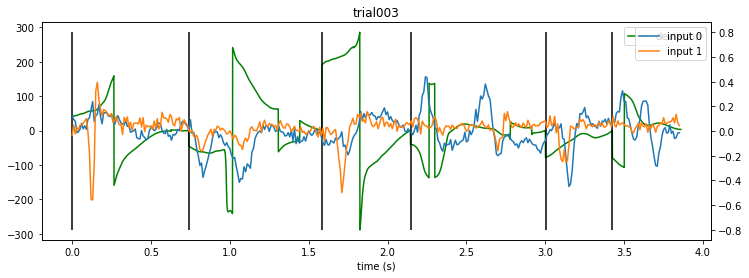

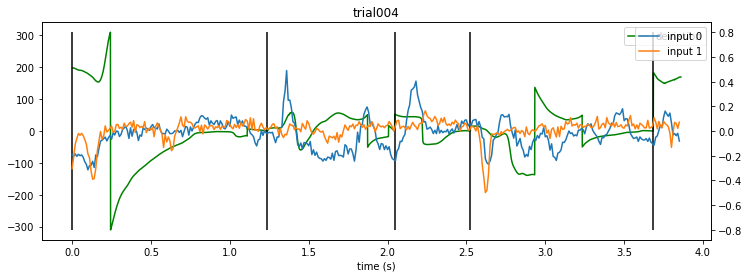

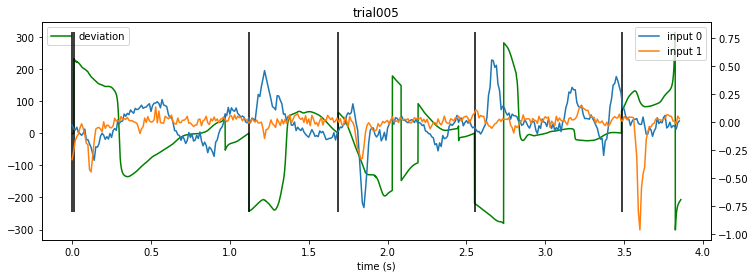

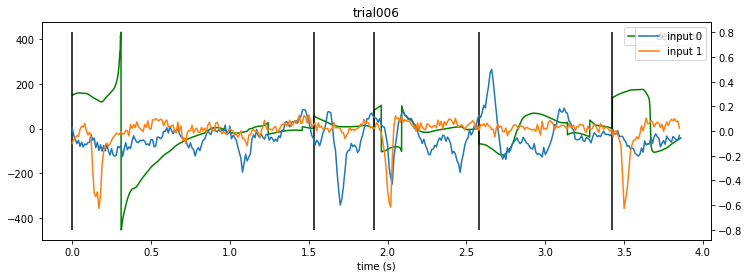

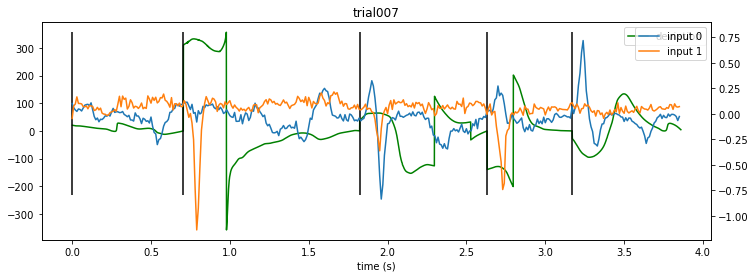

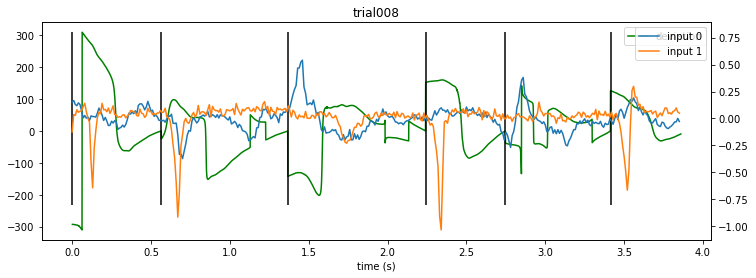

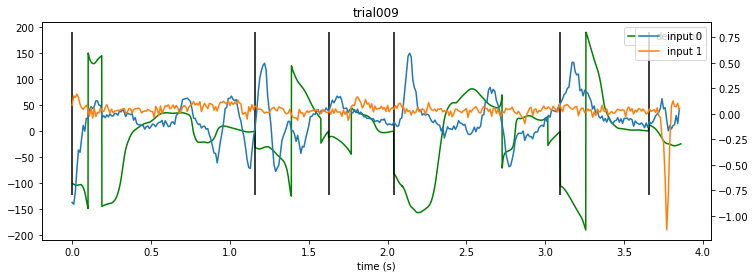

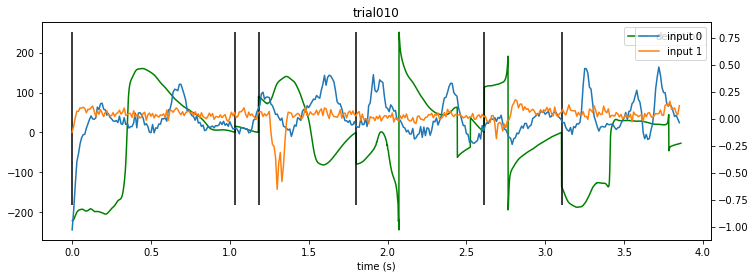

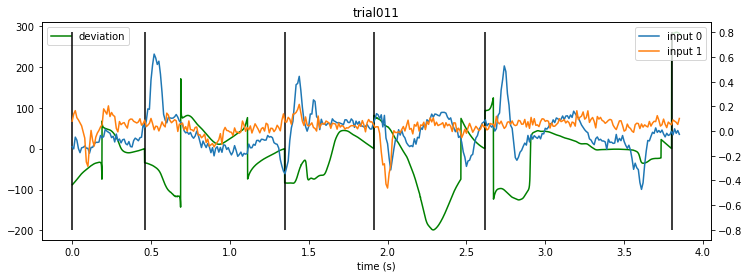

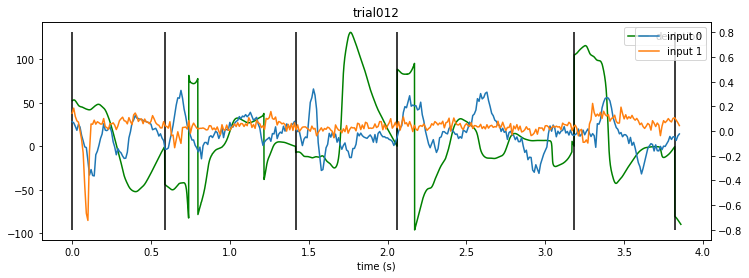

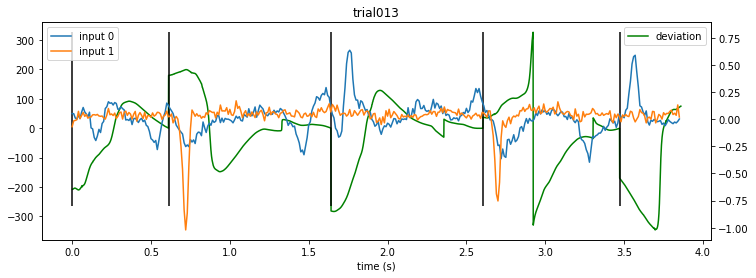

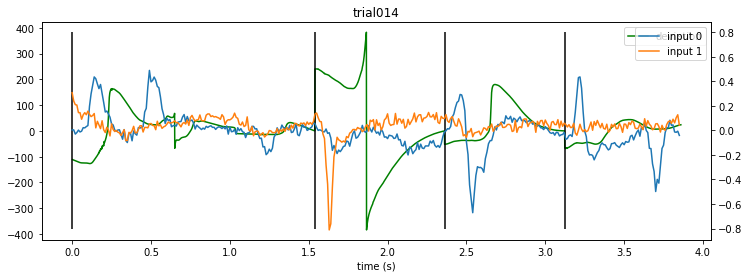

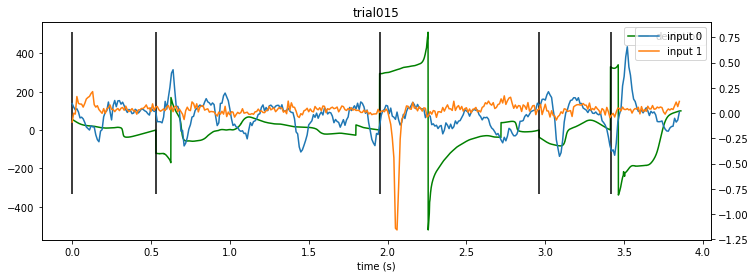

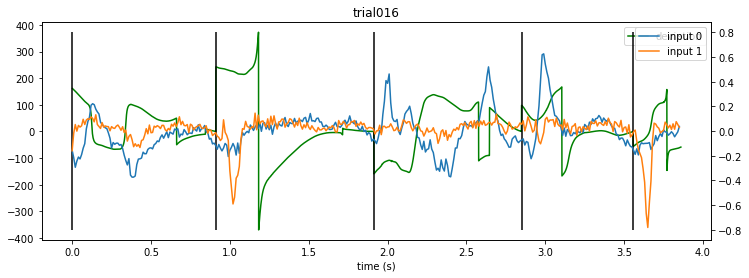

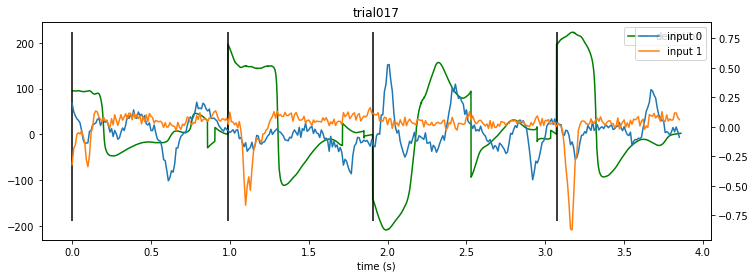

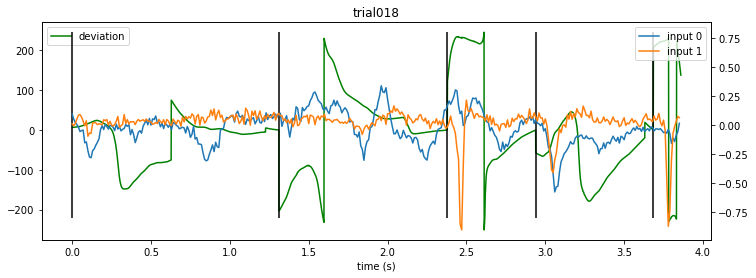

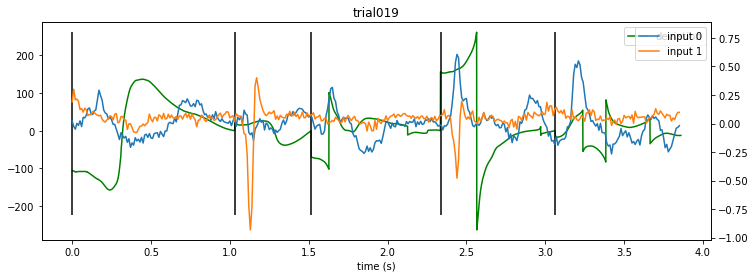

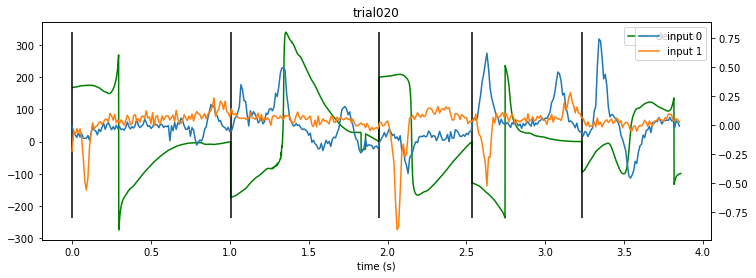

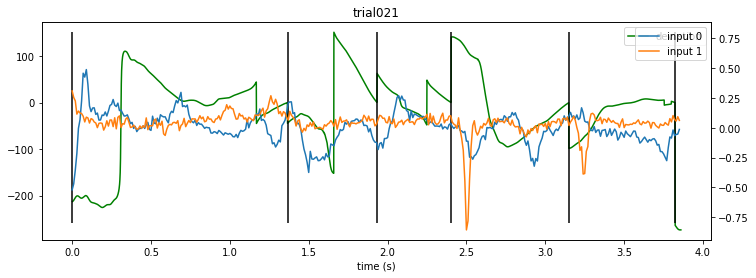

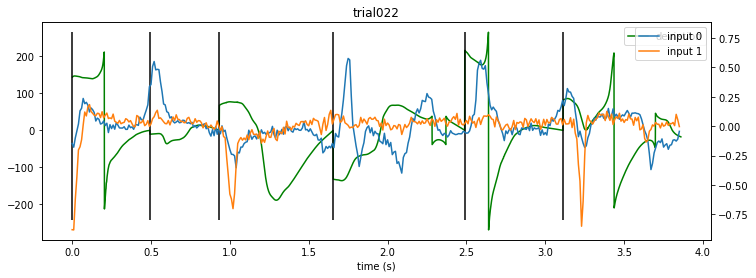

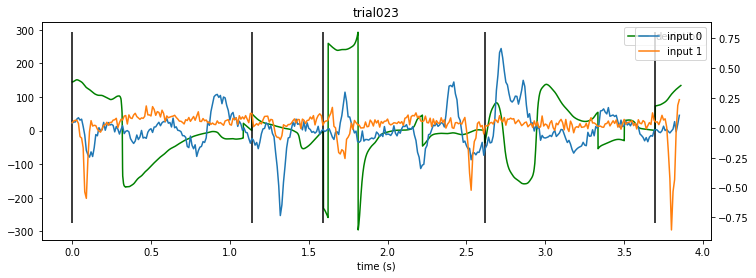

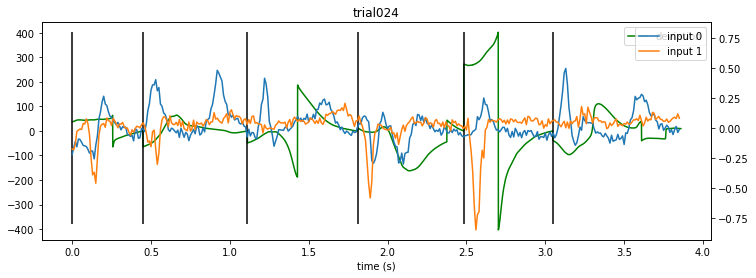

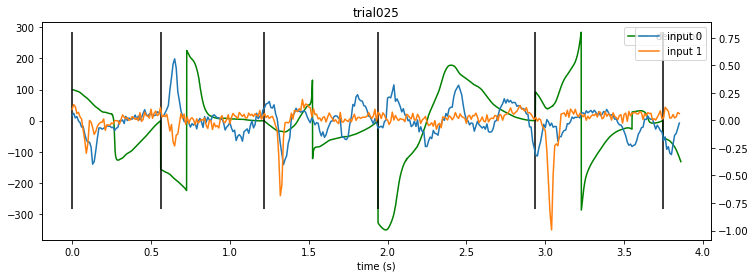

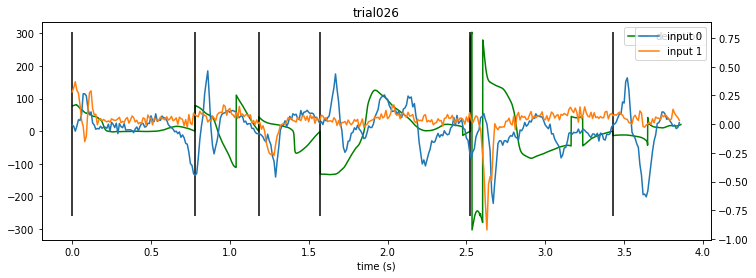

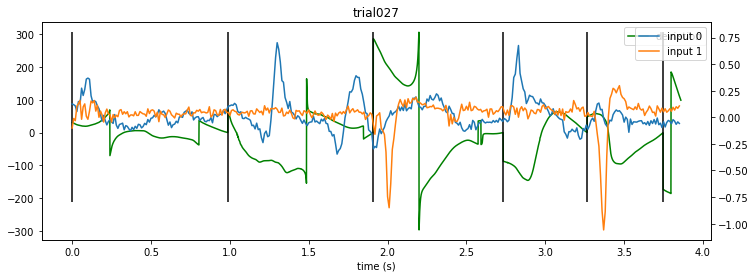

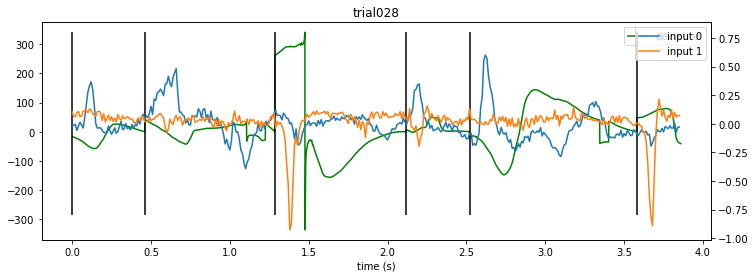

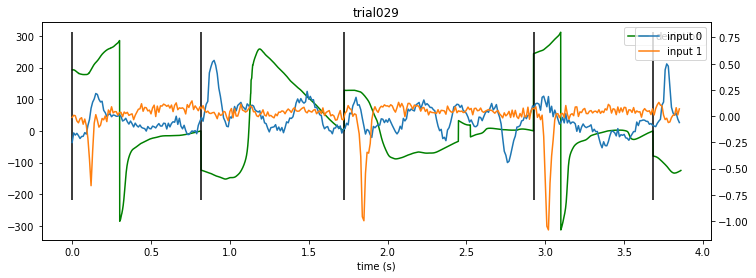

In [2]:
import numpy as np
import pandas as pd
import h5py
from scipy.io import loadmat
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src')
from power_law import get_power_law_deviation
from utils import get_indices

def angle_from_target(trial_df, trial_len):
    target_rows = trial_df.kinematic.query('hit_target')
    n_targets = trial_df.loc[:trial_len].kinematic.query('hit_target').shape[0]
    target_rows = target_rows.iloc[:n_targets + 1] #including target that isn't reached during the trial
    t_i = 0 #time of target
    j = 0
    n_samples = trial_df.loc[:trial_len].shape[0] #number of samples in trial
    angle = np.zeros(n_samples) #angle from hand velocity to target
    target_gen = target_rows.iterrows()
    next(target_gen)
    for t_ip1, row in target_gen:
        target_df = trial_df.loc[t_i:min(t_ip1-.0001,trial_len)].kinematic
        # truncating target samples for target that is present beyond the trial length
        if j + target_df.shape[0] <= n_samples:
            n = target_df.shape[0]
        else:
            n = n_samples - j

        #position of target in hand-centric coordinates
        target_x = row.x - target_df['x']
        target_y = row.y - target_df['y']
        r = np.sqrt(target_x**2 + target_y**2)
        try:
            angle[j:j+n] = r * np.arctan2(target_x - target_df['x_vel'].values, target_y - target_df['y_vel'])
        except:
            import pdb;pdb.set_trace()
        j += n
        t_i = t_ip1

    return angle

trial_type = 'all'

lfads_filename = "/home/pmalonis/226_figs/rockstar_8QTVEk_%s.h5"%trial_type
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/rockstar.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/rockstar_inputInfo.mat"

input_info = loadmat(inputInfo_filename)
used_inds = get_indices(input_info, trial_type)

df = pd.read_pickle(data_filename)

with h5py.File(lfads_filename) as h5file:
    trial_len_ms = input_info['seq_timeVector'][-1][-1]
    dt = np.round(trial_len_ms/h5file['controller_outputs'].shape[1])/1000 
    trial_len = trial_len_ms/1000
    trial_len = np.floor(trial_len/dt)*dt
    lfads_t = np.arange(0, trial_len, dt)
    for i, trial_idx in enumerate(used_inds[:30]):
        data_t = df.loc[trial_idx].loc[:trial_len].index.values
        x = df.loc[trial_idx].loc[:trial_len].kinematic['x'].values
        y = df.loc[trial_idx].loc[:trial_len].kinematic['y'].values
        angle = angle_from_target(df.loc[trial_idx], trial_len)
        plt.figure(figsize=(12,4))
        plt.plot(data_t, angle, 'g')
        plt.xlabel("time (s)")
        plt.legend(['angle deviation'])
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        plt.title('trial%03d'%trial_idx)
        n_inputs = h5file['controller_outputs'].shape[2]
        legend=[]
        targets = df.loc[trial_idx].kinematic.loc[:trial_len].query('hit_target').index.values
        plt.vlines(targets, -.8,.8)
        for input_idx in range(n_inputs):
            ax2.plot(lfads_t, h5file['controller_outputs'][i,:,input_idx])
            legend.append('input %d'%input_idx)

        plt.legend(legend)


It should be noted that even though the lfads controller inputs using data from Raju does not predict target position as well as the Rockstar dataset, the predictions of the hand kinematics from the LFADS factor outputs is similar to Rockstar, and better than using raw spikes. For the sake of time I've just attached a pdf showing this decoding performance rather than reproduce that plot here.  

Below I am examining the target prediction performance using polar hand-centric coordinates. First evaluating prediction of the angle, using circular $r^2$.

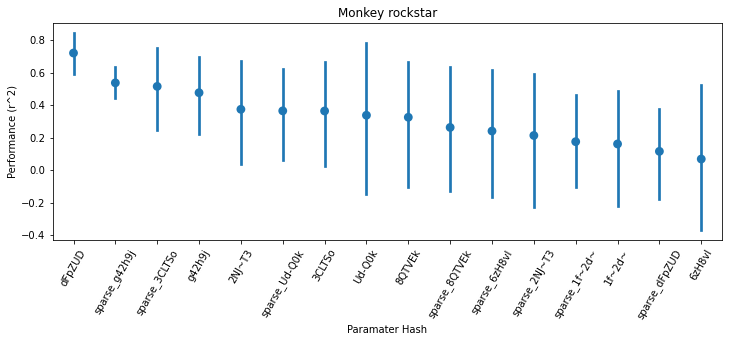

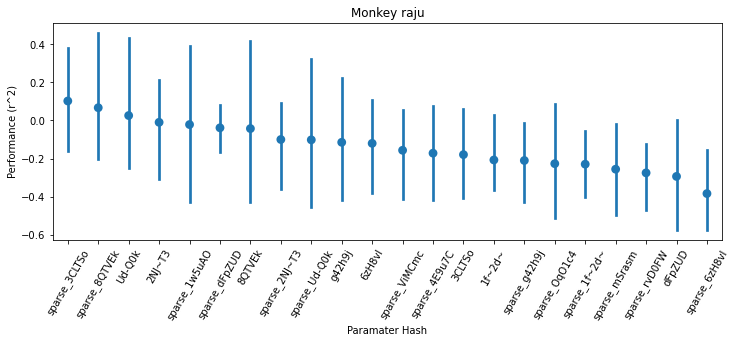

In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
from predict_targets import predict_targets
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

cfg = yaml.load(open('../config.yml'))

for dataset in ['rockstar', 'raju']:
    param_list = []
    performance = []
    k=0
    for param in cfg['datasets'][dataset]['params'].keys():
        df = pd.read_pickle('../data/processed_inputs/' + '%s_%s_all.p'%(dataset, param))
        scores = predict_targets(df, metric='angle')
        performance += list(scores)
        if '226' in param:
            param = 'sparse_' + param[4:]
        else:
            param = param[4:]
        param_list += [param]*len(scores)

    plot_df = pd.DataFrame(data={'Performance (r^2)':np.array(performance),
                                'Paramater Hash':np.array(param_list)})

    a=plot_df.groupby('Paramater Hash').mean().sort_values('Performance (r^2)', ascending=False)
    plt.figure(figsize=(12,4))
    g=sns.pointplot(x='Paramater Hash', y='Performance (r^2)', data=plot_df, join=False, order=a.index.values)
    g.set_xticklabels(g.get_xticklabels(), rotation=60)
    plt.title('Monkey %s'%dataset)

In [ ]:
Below I look at performance for predicting distance to the target.

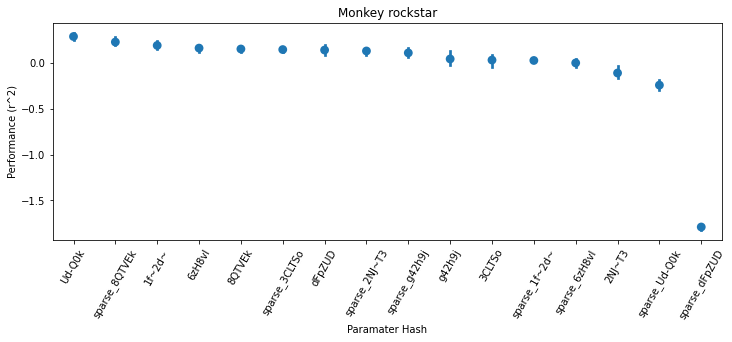

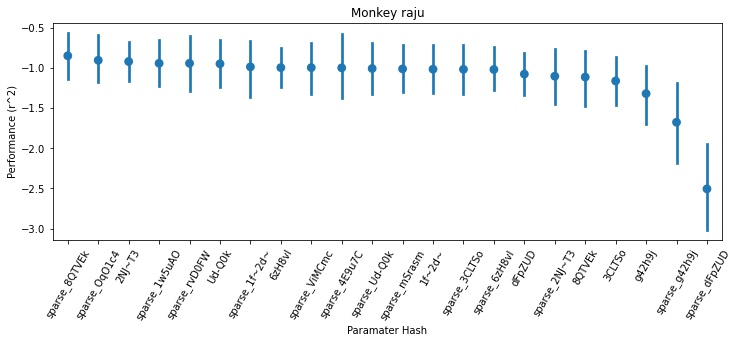

In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
from predict_targets import predict_targets
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

cfg = yaml.load(open('../config.yml'))

for dataset in ['rockstar', 'raju']:
    param_list = []
    performance = []
    k=0
    for param in cfg['datasets'][dataset]['params'].keys():
        df = pd.read_pickle('../data/processed_inputs/' + '%s_%s_all.p'%(dataset, param))
        scores = predict_targets(df, metric='distance')
        performance += list(scores)
        if '226' in param:
            param = 'sparse_' + param[4:]
        else:
            param = param[4:]
        param_list += [param]*len(scores)

    plot_df = pd.DataFrame(data={'Performance (r^2)':np.array(performance),
                                'Paramater Hash':np.array(param_list)})

    a=plot_df.groupby('Paramater Hash').mean().sort_values('Performance (r^2)', ascending=False)
    plt.figure(figsize=(12,4))
    g=sns.pointplot(x='Paramater Hash', y='Performance (r^2)', data=plot_df, join=False, order=a.index.values)
    g.set_xticklabels(g.get_xticklabels(), rotation=60)
    plt.title('Monkey %s'%dataset)

In [ ]:
Here, I seperated the populations for monkey raju into the two areas, M1 and PMd. I ran separate LFADS runs for each sub-network.

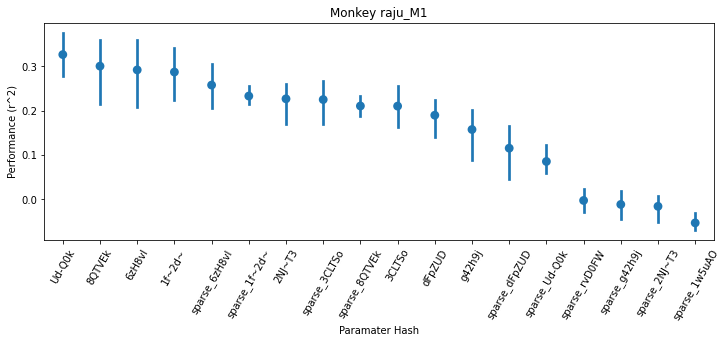

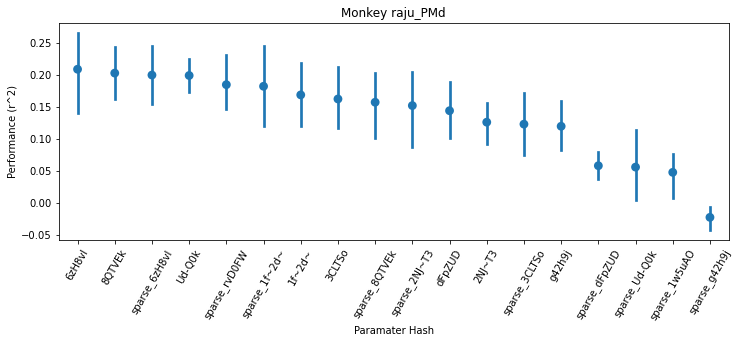

In [2]:
import numpy as np
import pandas as pd
import h5py
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
from predict_targets import predict_targets
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

cfg = yaml.load(open('../config.yml'))

for dataset in ['raju_M1', 'raju_PMd']:
    param_list = []
    performance = []
    k=0
    for param in cfg['datasets'][dataset]['params'].keys():
        df = pd.read_pickle('~aligned_peaks/' + '%s_%s_all.p'%(dataset, param))
        scores = predict_targets(df, metric='cartesian')
        performance += list(scores)
        if '226' in param:
            param = 'sparse_' + param[4:]
        else:
            param = param[4:]
        param_list += [param]*len(scores)

    plot_df = pd.DataFrame(data={'Performance (r^2)':np.array(performance),
                                'Paramater Hash':np.array(param_list)})

    a=plot_df.groupby('Paramater Hash').mean().sort_values('Performance (r^2)', ascending=False)
    plt.figure(figsize=(12,4))
    g=sns.pointplot(x='Paramater Hash', y='Performance (r^2)', data=plot_df, join=False, order=a.index.values)
    g.set_xticklabels(g.get_xticklabels(), rotation=60)
    plt.title('Monkey %s'%dataset)

Below are example plots for the M1 and PMd networks trials using the same hyperparameter set for both.

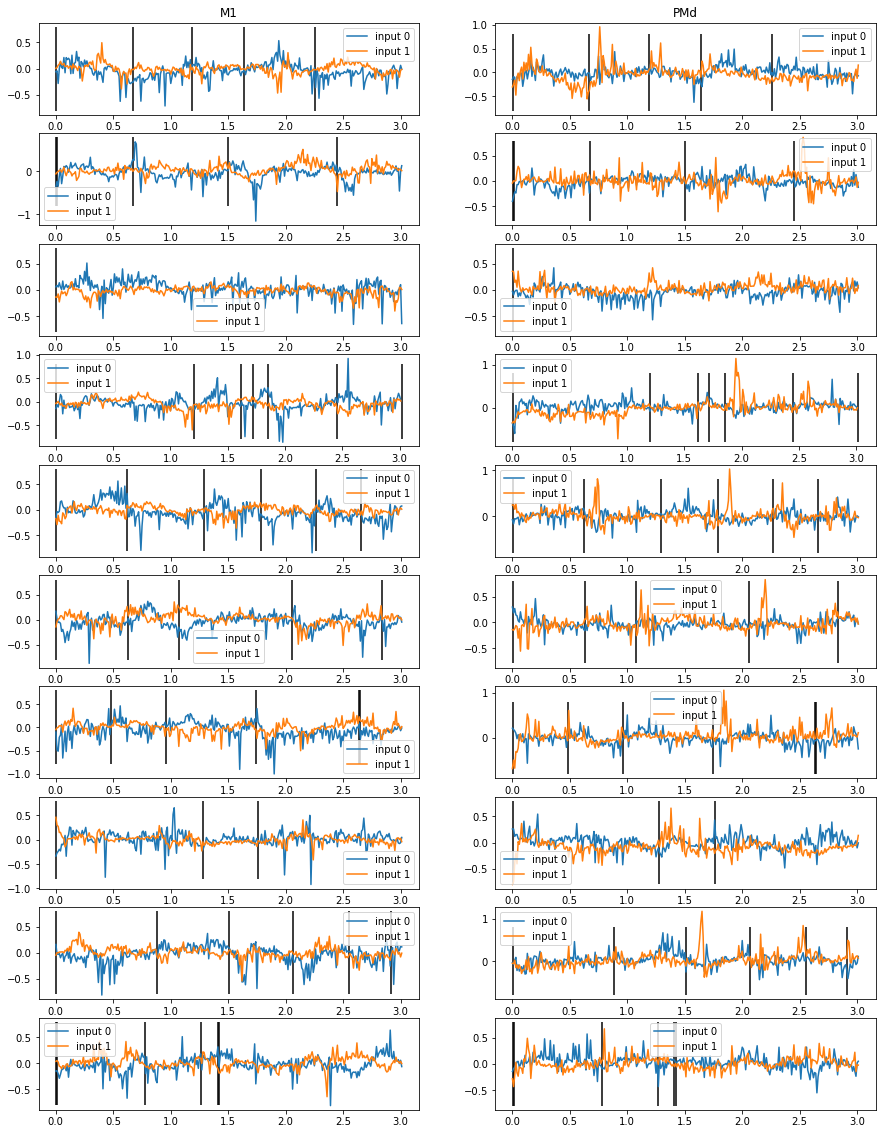

In [4]:
from scipy.io import loadmat
import sys
import h5py
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
from utils import get_indices
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

trial_type = 'valid'

sparse_filename = "/home/pmalonis/lfads_analysis/data/model_output/raju_PMd_6zH8vI_%s.h5"%trial_type
gauss_filename =  "/home/pmalonis/lfads_analysis/data/model_output/raju_M1_6zH8vI_%s.h5"%trial_type
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/raju.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/raju_inputInfo.mat"

input_info = loadmat(inputInfo_filename)
used_inds = get_indices(input_info, trial_type)

df = pd.read_pickle(data_filename)
ntrials = 10

with h5py.File(gauss_filename) as gauss_h5:
    with h5py.File(sparse_filename) as sparse_h5:
        trial_len_ms = input_info['seq_timeVector'][-1][-1]
        dt = np.round(trial_len_ms/gauss_h5['controller_outputs'].shape[1])/1000
        trial_len = trial_len_ms/1000
        trial_len = np.floor(trial_len/dt)*dt
        lfads_t = np.arange(0, trial_len, dt)
        plt.figure(figsize=(15,20))
        for j, (h5file,title) in enumerate(zip([gauss_h5, sparse_h5], ['M1', 'PMd'])):
            for i, trial_idx in enumerate(used_inds[:ntrials]):
                plt.subplot(ntrials, 2, i*2 + j + 1)
                n_inputs = h5file['controller_outputs'].shape[2]
                targets = df.loc[trial_idx].kinematic.loc[:trial_len].query('hit_target').index.values
                plt.vlines(targets, -.8,.8)
                legend = []
                for input_idx in range(n_inputs):
                    plt.plot(lfads_t, h5file['controller_outputs'][i,:,input_idx])
                    legend.append('input %d'%input_idx)

                if i == 0:
                    plt.title(title)
                plt.legend(legend)

Finally, I am documenting here my attempt to start to understand if the dynamics in between input pulses are truly autonomous. I attempted to recreate the LFADS generator so I could run it forward from any initial condition without inputs. I attempted to validate that this worked using an LFADS run that has no input, but I could not reproduce generator dynamics:

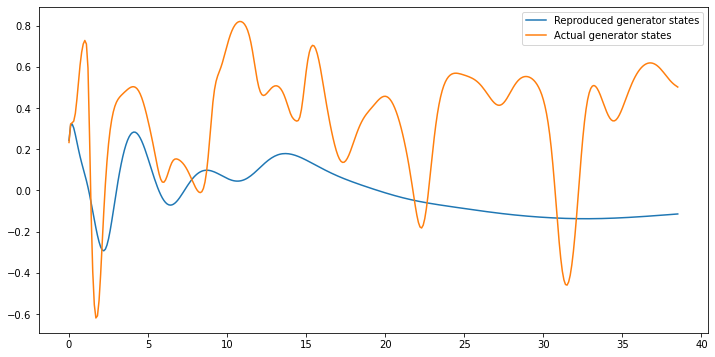

In [10]:
from scipy.io import loadmat
import h5py

param_file = "/home/pmalonis/lfads_analysis/data/model_output/no_controller_params.mat"
push_mean_file = "/home/pmalonis/lfads_analysis/data/model_output/model_runs_rockstar.h5_train_posterior_push_mean"
forget_bias = 1.0

params = loadmat(param_file)
W_hru=params['gen_gengru_h_to_ru_W']
b_hru=params['gen_gengru_h_to_ru_b']
W_rhc=params['gen_gengru_rh_to_c_W']
b_rhc=params['gen_gengru_rh_to_c_b']

sig = lambda x: 1/(1+np.exp(-x))
with h5py.File(push_mean_file) as push_mean:
    h = np.array([push_mean['gen_ics'][0,:]])
    gen_states = np.zeros_like(push_mean['gen_states'][0,:])
    for i in range(gen_states.shape[0]):
        weight_scale = 1#/np.sqrt(len(h))
        r=sig(weight_scale*h.dot(W_hru)[0,:200] + b_hru[0,:200])
        u=sig(weight_scale*h.dot(W_hru)[0,200:] + b_hru[0,200:] + forget_bias)
        c=np.tanh(weight_scale*(r*h).dot(W_rhc) + b_rhc)
        h=u*h + (1-u)*c
        gen_states[i,:] = h

from pickle import load

dt = 0.01
t = np.arange(0,gen_states.shape[0])*dt

with h5py.File(push_mean_file) as f:
    push_mean_gen_states = f['gen_states'][0,:,:]

plt.figure(figsize=(12,6))
plt.plot(t, gen_states[:,1])
plt.plot(t, push_mean_gen_states[:,1])
plt.xlabel('time (s)')
plt.ylabel('Generator state')

plt.legend(['Reproduced generator states', 'Actual generator states'])


I also reproduced the same incorrect dynamics an using an entirely different method, employing LFADS objects. I've concluded that this approach would not be a good investment of time, and will try other approaches to the question of characterizing autonomous dynamics.